This notebook illustrates running the deAlmeida overland flow component in an extremely simple-minded way on a real topography, then shows it creating a flood sequence along an inclined surface with an oscillating water surface at one end.

First, import what we'll need:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from pymt.models import OverlandFlow

➡ models: FrostNumber, Ku, ExponentialWeatherer, Flexure, FlowAccumulator, FlowDirectorD8, FlowDirectorDINF, FlowDirectorSteepest, FlowRouter, LinearDiffuser, OverlandFlow, SoilMoisture, StreamPowerEroder, TransportLengthHillslopeDiffuser, Vegetation, Hydrotrend, Cem, Waves


Pick the initial and run conditions

In [2]:
run_time = 60.0 * 60.0  # duration of run, (s)
time_step = 60.0
h_init = 0.1  # initial thin layer of water (m)

Get the [example DEM](https://github.com/landlab/tutorials/blob/release/overland_flow/Square_TestBasin.asc). This DEM is an ESRII ASCII file so we can use numpy to load it into a numpy array (note that there are 5 header lines). The following command will download it for you.

In [3]:
import urllib.request

path_to_dem, _ = urllib.request.urlretrieve(
    "https://raw.githubusercontent.com/landlab/tutorials/release/overland_flow/Square_TestBasin.asc"
)

In [4]:
z = np.flipud(np.loadtxt(path_to_dem, skiprows=5))
n_rows, n_cols = z.shape
spacing = 30.0  # The spacing of the DEM is 30 m

In [5]:
overland_flow = OverlandFlow()
config_file, config_dir = overland_flow.setup(

    grid_row_spacing=spacing,
    grid_column_spacing=spacing,
    grid_rows=n_rows,
    grid_columns=n_cols,

    clock_start=0.0,
    clock_stop=run_time,
    clock_step=time_step,
    
    steep_slopes=True,  # For stability in steeper environments, we set the steep_slopes flag to True
)
overland_flow.initialize(config_file, config_dir)

In [6]:
status_at_node = np.zeros_like(z)
status_at_node[(0, -1), :] = 4
status_at_node[:, (0, -1)] = 4

my_outlet_node = 100  # This DEM was generated using Landlab and the outlet node ID was known
status_at_node[0, my_outlet_node] = 1  # 1 is the code for fixed value

overland_flow.set_value("boundary_condition_flag", status_at_node)

In [7]:
overland_flow.set_value("topographic__elevation", z)
overland_flow.set_value("surface_water__depth", h_init)

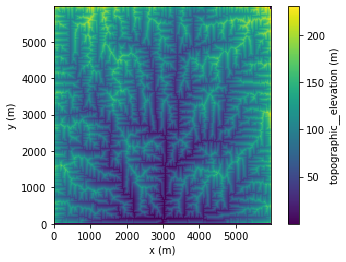

In [8]:
overland_flow.quick_plot("topographic__elevation")

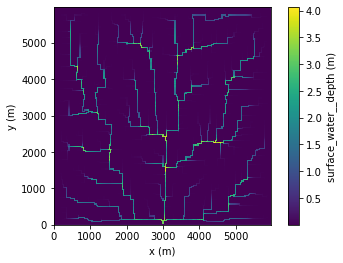

In [9]:
h_everywhere = []
for _ in range(10):
    overland_flow.update()
    h_everywhere.append(overland_flow.get_value("surface_water__depth"))

overland_flow.quick_plot("surface_water__depth")

In [10]:
water_depth = overland_flow.get_value("surface_water__depth").reshape(z.shape)
water_depth[-50:, :] = 10.0 * h_init
overland_flow.set_value("surface_water__depth", water_depth)

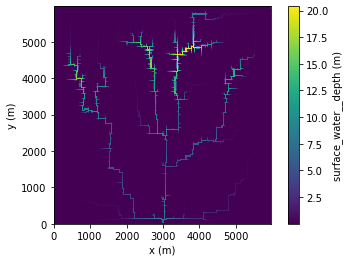

In [11]:
for _ in range(10):
    overland_flow.update()
    h_everywhere.append(overland_flow.get_value("surface_water__depth"))
overland_flow.quick_plot("surface_water__depth")

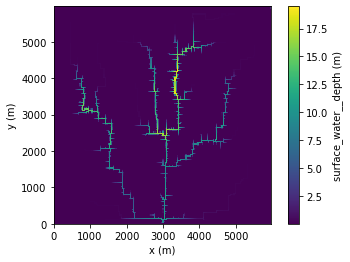

In [12]:
for _ in range(10):
    overland_flow.update()
    h_everywhere.append(overland_flow.get_value("surface_water__depth"))
overland_flow.quick_plot("surface_water__depth")

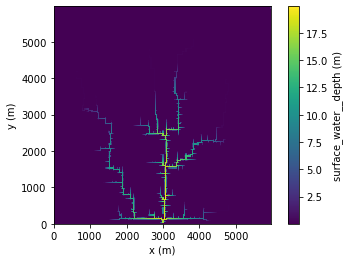

In [13]:
while overland_flow.time < overland_flow.end_time:
    overland_flow.update()
    h_everywhere.append(overland_flow.get_value("surface_water__depth"))
overland_flow.quick_plot("surface_water__depth")

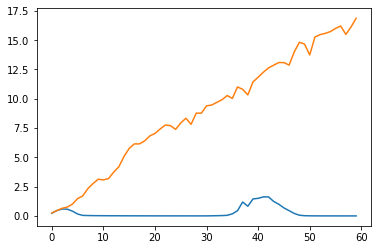

In [14]:
h_everywhere = np.array(h_everywhere).reshape((-1, 200, 200))

plt.figure()
_ = plt.plot(h_everywhere[:, 100, 120])
_ = plt.plot(h_everywhere[:, 1, 100])